In [18]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'


from sklearn.preprocessing import MinMaxScaler


In [130]:
df = pd.read_csv("/content/TATASTEEL.csv")

In [131]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,TISCO,EQ,142.35,148.00,153.2,146.10,152.50,152.45,150.92,2003185,3.023164e+13,NaN,NaN,NaN
1,2000-01-04,TISCO,EQ,152.45,150.10,153.0,143.05,151.95,150.80,151.03,1555136,2.348785e+13,NaN,NaN,NaN
2,2000-01-05,TISCO,EQ,150.80,144.60,162.9,144.60,158.00,156.55,156.85,3840284,6.023364e+13,NaN,NaN,NaN
3,2000-01-06,TISCO,EQ,156.55,158.95,169.1,158.95,169.00,168.25,167.61,2560449,4.291530e+13,NaN,NaN,NaN
4,2000-01-07,TISCO,EQ,168.25,173.40,179.0,166.30,170.55,171.95,173.89,3641691,6.332459e+13,NaN,NaN,NaN


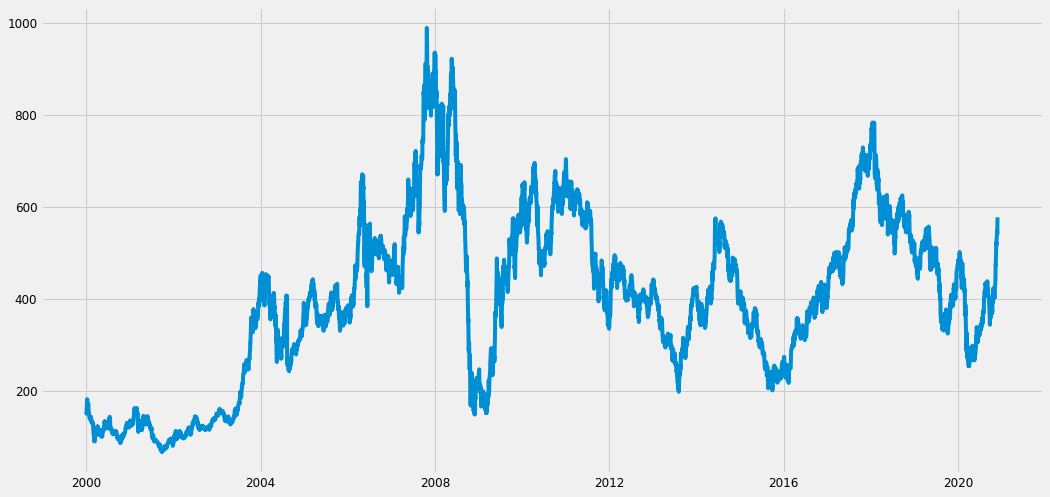

In [132]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')
# plt.savefig("fig1.png",dpi=600)

In [133]:


data=df.sort_index(ascending=True,axis=0)

new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [134]:
new_dataset

,Date,Close
0,2000-01-03 00:00:00,152.45
1,2000-01-04 00:00:00,150.8
2,2000-01-05 00:00:00,156.55
3,2000-01-06 00:00:00,168.25
4,2000-01-07 00:00:00,171.95
...,...,...
5199,2020-11-23 00:00:00,543.1
5200,2020-11-24 00:00:00,548.3
5201,2020-11-25 00:00:00,541.25
5202,2020-11-26 00:00:00,568.4


In [135]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [136]:
new_dataset

,Close
Date,
2000-01-03,152.45
2000-01-04,150.8
2000-01-05,156.55
2000-01-06,168.25
2000-01-07,171.95
...,...
2020-11-23,543.1
2020-11-24,548.3
2020-11-25,541.25


In [137]:
final_dataset=new_dataset.values

In [138]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values

train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]



scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

# LSTM Model

In [139]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 24s - loss: 3.1618e-04


In [140]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

In [141]:
lstm_model.save("saved_model.h5")


In [142]:

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


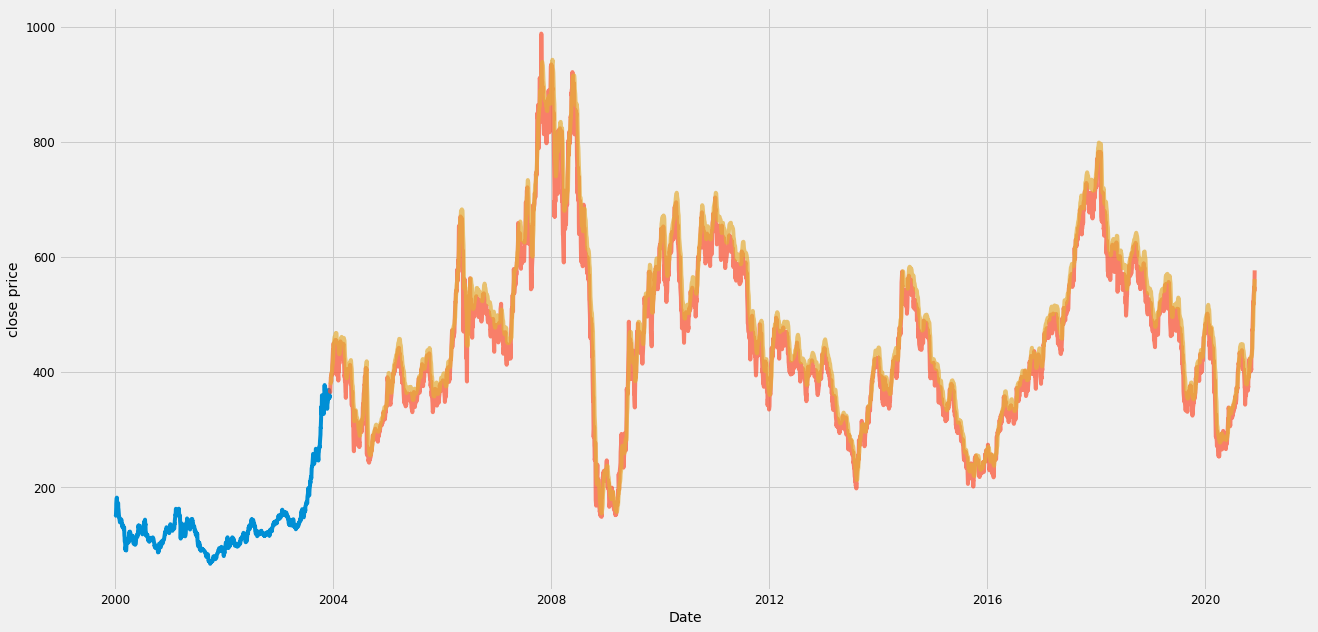

In [143]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]], alpha= .7)
plt.xlabel('Date')
plt.ylabel('close price')
plt.savefig("fig2.png",dpi=600)


In [ ]:
#rms=np.sqrt(np.mean(np.power((np.array(valid_data['Close'])-valid_data['Predictions']),2)))
#print('\n RMSE value on validation set:')
#print(rms)

# Facbook Prophet

In [63]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

In [83]:
#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:987]
valid = new_data[987:]

In [84]:
#fit the model
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [85]:
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

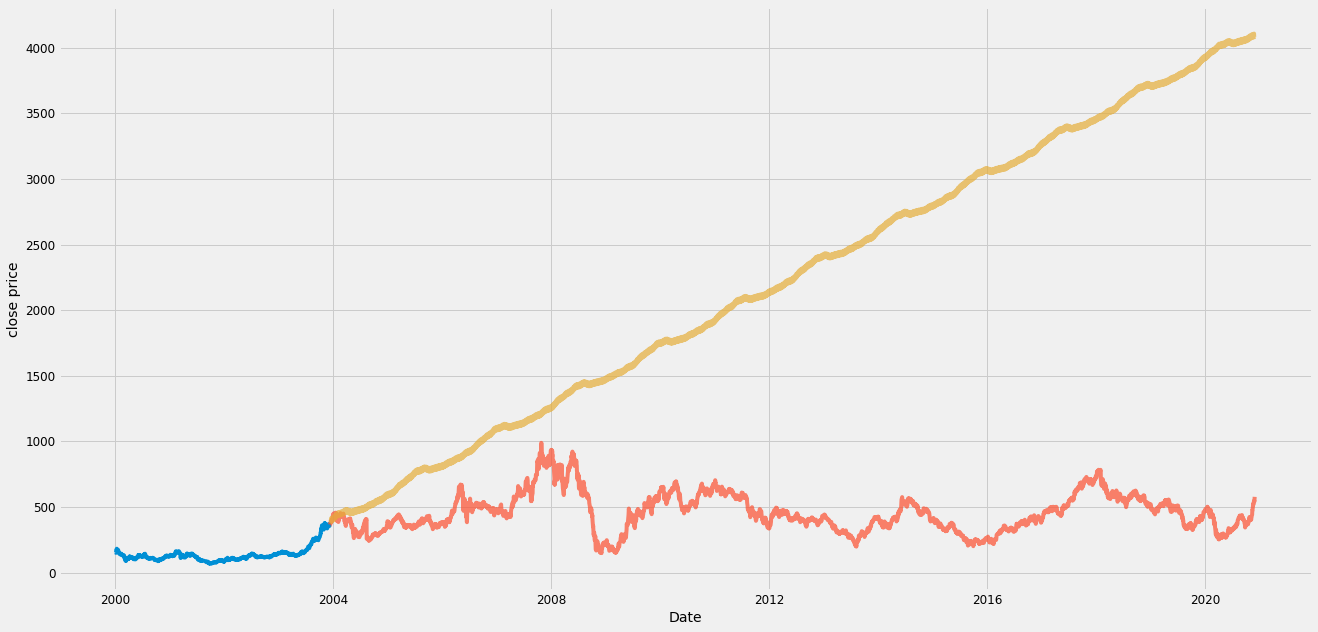

In [86]:
forecast_valid = forecast['yhat'][987:]
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']],alpha=.7)
plt.xlabel('Date')
plt.ylabel('close price')
plt.savefig("fig3.png",dpi=600)

In [87]:
forecast_valid = forecast['yhat'][987:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

2092.717647115142

In [33]:
# arima 
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [69]:
df1 = pd.read_csv('/content/TATASTEEL.csv')
stock=df1

In [70]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

In [71]:
cols = ['Symbol',	'Series',	'Prev Close',	'Open',	'High',	'Low',	'Last',	'VWAP',	'Volume',	'Turnover',	'Trades',	'Deliverable Volume',	'%Deliverble']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')

In [72]:

stock = stock.groupby('Date')['Close'].sum().reset_index()


In [73]:
stock = stock.set_index('Date')
stock.index

Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2020-11-14', '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
       '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26', '2020-11-27'],
      dtype='object', name='Date', length=5204)

In [74]:
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()

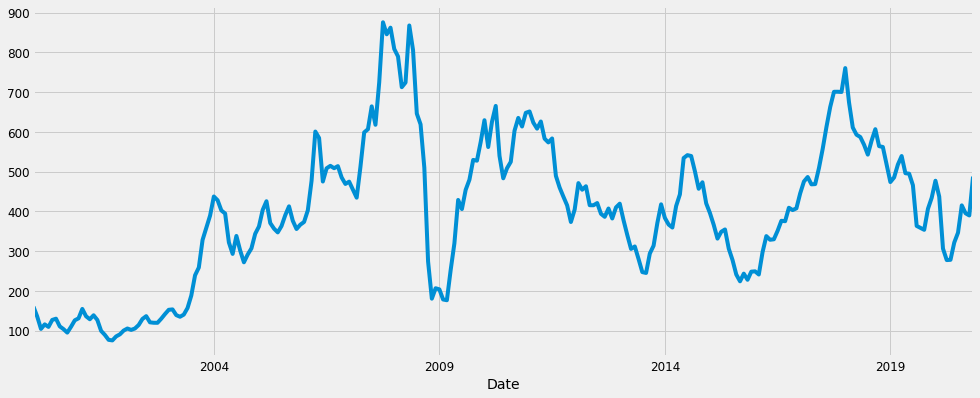

In [75]:

monthly_mean.plot(figsize=(15, 6))
plt.show()

In [76]:
#We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

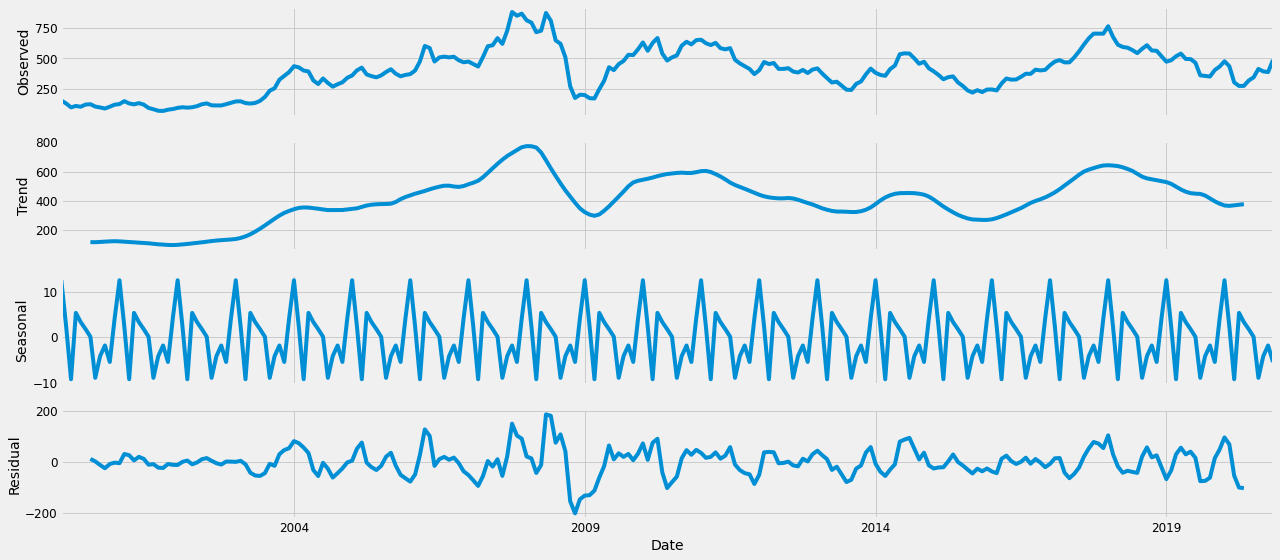

In [77]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [78]:

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [79]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3751.975755986141
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3418.3451686037647
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3186.823491704443
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2986.4960470652436
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3193.213476806388
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3137.320758575579
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3015.1745793484315
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2988.4635154184543
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3411.337495454666
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3098.523310857503
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2886.922297580651
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2704.7800914203344
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2902.8654772653617
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2843.476534989347
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2744.3743923311986
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2706.7800306756135
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2610.1646226764606
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2491.126042834864
A

In [80]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [81]:

mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4512      0.093     -4.836      0.000      -0.634      -0.268
ma.L1          0.8124      0.064     12.605      0.000       0.686       0.939
ma.S.L12      -1.0000      0.073    -13.612      0.000      -1.144      -0.856
sigma2      1915.0801   3.84e-05   4.99e+07      0.000    1915.080    1915.080


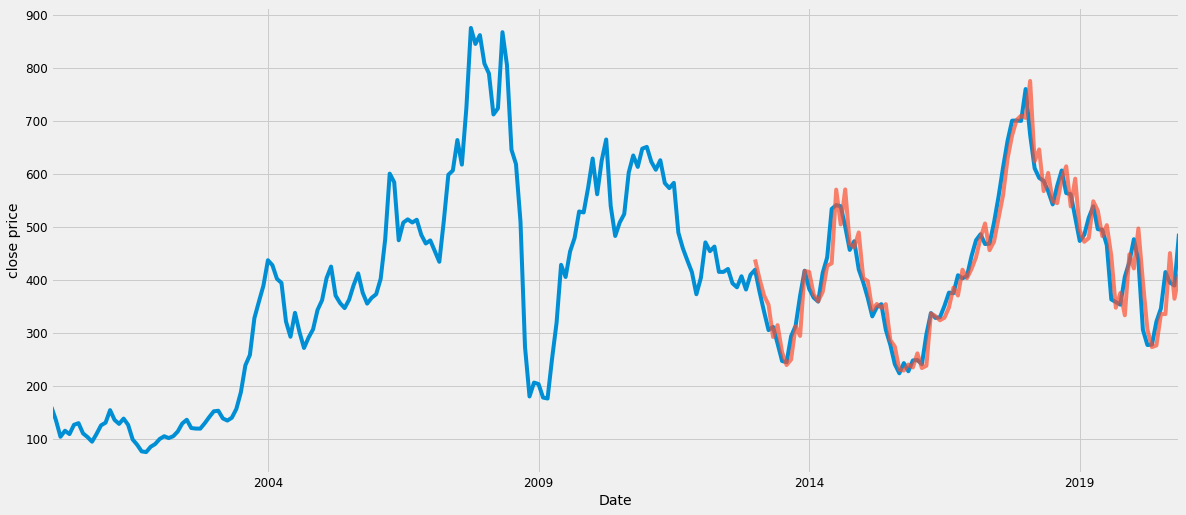

In [82]:

pred = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2000':].plot()
pred.predicted_mean.plot(ax=ax, alpha=.7)



ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.savefig("fig3.png",dpi=600)

plt.show()

In [83]:

y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2014-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1543.25


In [84]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 39.28
